In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [10]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from source.visualization.evaluation_visualization import plot_loss_curve
from source.visualization.image_visualization import plot_images_with_matches_via_match_matrix
from torch.utils.data import DataLoader
import torch
from einops.einops import rearrange
from torchvision.transforms import v2
from source.loftr.loss import *

In [3]:
crop_size = 640
transformation_threshold = 0.15
patch_size = 16
max_translation_shift = 50
fine_feature_size = 160
images_directory = "../../data/cyto_downscaled_3344_3904/"

dataset_test = BrainDataset(
    images_directory=images_directory,
    train=False,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_feature_size=fine_feature_size,
    transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]))

dataloader_test = DataLoader(
    dataset=dataset_test,
    batch_size=1,
    shuffle=True,
    pin_memory=False,
    drop_last=True,
)

In [4]:
model_name = "lr0p0007_wd0p0015_coarse_contextFalse_img_size3344_3904_ResNet16_4_transform_threshold0p3_temp0p2_bs2_coarse_lossfocal_fine_lossl2_std_trainTrue_gamma1p5_alpha0p55_v3"

In [5]:
confidence_threshold = 0.3

block_dimensions = [64, 96, 128, 192]
fine_feature_size = block_dimensions[1]
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).cuda()
backbone.load_state_dict(torch.load(f"../../models/{model_name}/backbone.pt"))


positional_encoding = PositionalEncoding(coarse_feature_size).cuda()

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).cuda()
coarse_loftr.load_state_dict(torch.load(f"../../models/{model_name}/coarse_loftr.pt"))

coarse_matcher = CoarseMatching(temperature=0.1, confidence_threshold=confidence_threshold).cuda()

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=False,
).cuda()

fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).cuda()
fine_loftr.load_state_dict(torch.load(f"../../models/{model_name}/fine_loftr.pt"))


fine_matching = FineMatching().cuda()

params = list(backbone.parameters()) + list(coarse_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=0.001, lr=0.0008)

In [6]:
backbone.eval()
coarse_loftr.eval()
fine_loftr.eval()

LocalFeatureTransformer(
  (layers): ModuleList(
    (0-1): 2 x LoFTREncoderLayer(
      (q_projection): Linear(in_features=96, out_features=96, bias=False)
      (k_projection): Linear(in_features=96, out_features=96, bias=False)
      (v_projection): Linear(in_features=96, out_features=96, bias=False)
      (attention): LinearAttention()
      (merge): Linear(in_features=96, out_features=96, bias=False)
      (mlp): Sequential(
        (0): Linear(in_features=192, out_features=192, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=192, out_features=96, bias=False)
      )
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [19]:
max_loss = 0

with torch.no_grad():
    for epoch in range(30):
        print(f"Epoch {epoch}")
        for (
            image_1_crop,
            image_2_crop,
            match_matrix_ground_truth,
            relative_coordinates,
            crop_coordinate_mapping,
        ) in dataloader_test:
            image_1_crop = image_1_crop.cuda()
            image_2_crop = image_2_crop.cuda()
            match_matrix_ground_truth = match_matrix_ground_truth.cuda()
            relative_coordinates = relative_coordinates.cuda()

            coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
            coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)

            coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
            coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

            coarse_image_feature_1 = rearrange(
                coarse_image_feature_1, "n c h w -> n (h w) c"
            )
            coarse_image_feature_2 = rearrange(
                coarse_image_feature_2, "n c h w -> n (h w) c"
            )

            coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
                coarse_image_feature_1, coarse_image_feature_2
            )

            coarse_matches_predicted = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)
            match_matrix_predicted = coarse_matches_predicted["match_matrix"]

            coarse_loss = coarse_cross_entropy_loss(
                predicted_confidence=coarse_matches_predicted["confidence_matrix"],
                ground_truth_confidence=match_matrix_ground_truth)

            if coarse_loss > max_loss:
                max_loss = coarse_loss
                max_loss_data = (image_1_crop, image_2_crop, coarse_matches_predicted["match_matrix"], match_matrix_ground_truth)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [20]:
max_loss

tensor(9.6485, device='cuda:0')

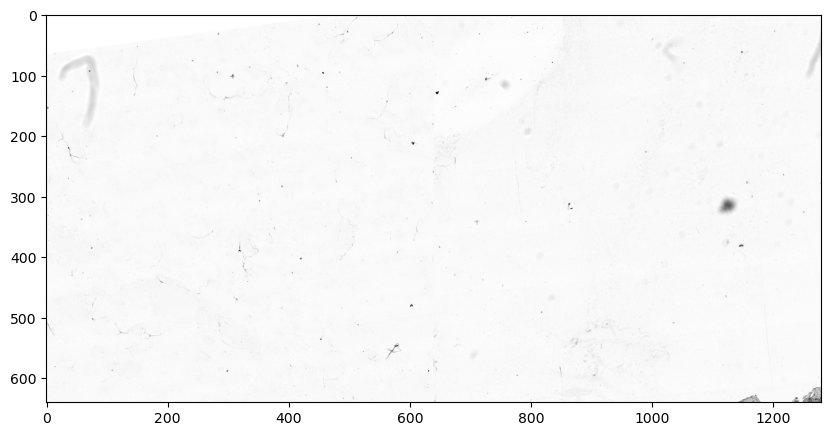

In [22]:
plot_images_with_matches_via_match_matrix(image_1=max_loss_data[0][0].cpu(), 
                                          image_2=max_loss_data[1][0].cpu(), 
                                          ground_truth_match_matrix=max_loss_data[3][0].cpu(), 
                                          predicted_match_matrix=max_loss_data[2][0].cpu(), visualization_mode="lines", line_frequency=1)


In [28]:
max_loss_data[2].sum()

tensor(0, device='cuda:0')

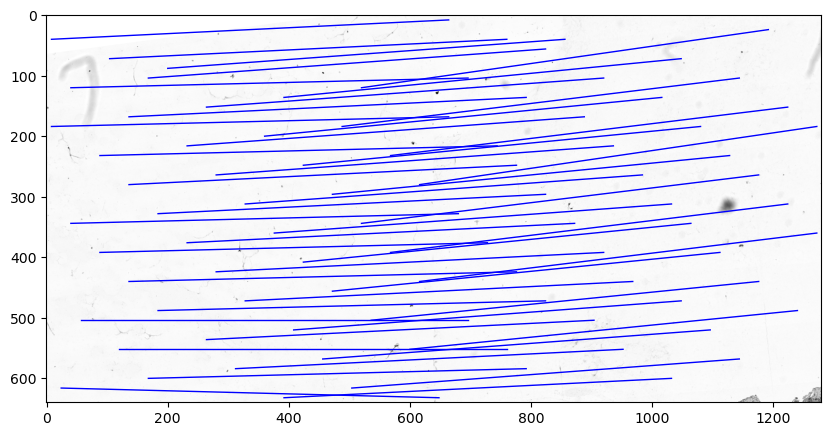

In [24]:
plot_images_with_matches_via_match_matrix(image_1=max_loss_data[0][0].cpu(), 
                                          image_2=max_loss_data[1][0].cpu(), 
                                          ground_truth_match_matrix=max_loss_data[3][0].cpu(), visualization_mode="lines", line_frequency=30)
